# Notebook 1 - Read, Smooth, and Condition a DEM

This first jupyter notebook uses a polygon area of interest to read in a DEM from the USGS API, smooth the DEM using a bespoke smoothing method in the 'WhiteboxTools' python package, and conditions the DEM by breaching depressions also using WhiteboxTools.

NOTE: these conditioning steps are conducted in a separate notebook as the python packages required for the microwatershed delineation are incompatible with WhiteboxTools, which is needed for the conditioning.

Note: ensure to install the necessary python packages included in the venv39_dem.txt file.
A virtual environment with python version 3.9.13 must be used to ensure the package dependencies align.

In [1]:
# Import packages
import os
import leafmap # pip install leafmap[raster]
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Initialize a map for plotting

m = leafmap.Map(center=[27.5, -80.3], zoom=12, height="600px")
# m

# Step 1 - Read DEM

In [38]:
# Read in a polygon - this will serve as the area of interest that will get smoothed/conditioned

# Recommended to create a polygon area of interest in ArcGIS Pro or similar, export the polygon as a shapefile, save it to the data-inputs folder, and read it in here

# Waterway village area for testing (smaller area)
wwv = gpd.read_file(r'data-inputs\\IRL-Boundary\\WaterwayVillage-Boundary.shp')
# Full IRL region
irl = gpd.read_file(r'data-inputs\\IRL-Boundary\\IRL-AOI_4326.shp')

# Path to save the DEM
output_path = 'data-inputs\leafmap'
dem_filename = 'wwv-10m'

# Read in DEM for area of interest from USGS API
leafmap.get_3dep_dem(
    wwv, # specifyAOI polygon
    resolution=10, # specify a resolution in meters. 10m is the default value for the microwatershed delineation
    output=f"{output_path}\{dem_filename}.tif", # specify file name 
    dst_crs="EPSG:4326", # specify coordinate reference system - must be 4326 for the microwatershed delineation
    to_cog=True
)

File data-inputs\leafmap\wwv-10m.tif already exists. Set overwrite=True to overwrite it


In [39]:
# Define a function for plotting
def plot_dem(dem_path):
    # Open the DEM file
    with rasterio.open(dem_path) as src:
        dem = src.read(1)  # Read the first band
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Get spatial extent

    # Mask no-data values
    dem = np.where(dem == src.nodata, np.nan, dem)

    # Plot the DEM
    plt.figure(figsize=(8, 6))
    plt.imshow(dem, cmap="terrain", extent=extent, origin="upper")
    plt.colorbar(label="Elevation (m)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Digital Elevation Model (DEM)")
    plt.show()

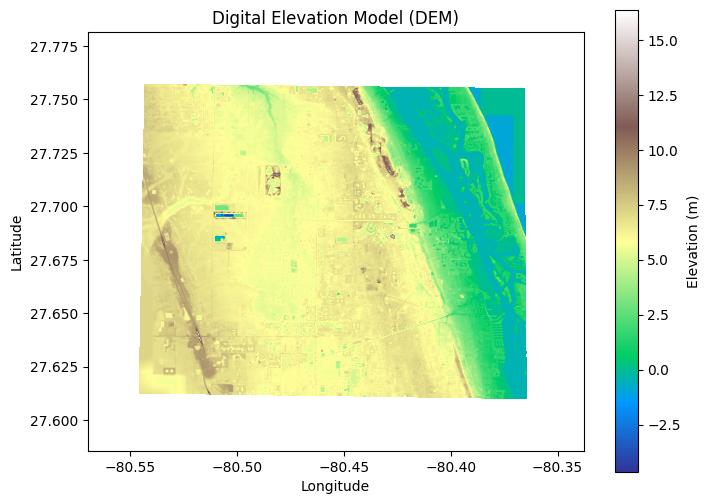

In [40]:
# Plot the DEM
dem_path = f'{output_path}\{dem_filename}.tif'
plot_dem(dem_path)

In [41]:
metadata = leafmap.image_metadata(dem_path)
metadata

{'bounds': {'left': -80.569805,
  'bottom': 27.585716,
  'right': -80.337849,
  'top': 27.781504},
 'crs': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'band_metadata': [('b1', {})],
 'band_descriptions': [('b1', 'elevation')],
 'dtype': 'float32',
 'nodata_type': 'Nodata',
 'colorinterp': ['gray'],
 'scales': [1.0],
 'offsets': [0.0],
 'colormap': None,
 'driver': 'GTiff',
 'count': 1,
 'width': 2546,
 'height': 2149,
 'overviews': [2, 4, 8],
 'nodata_value': nan,
 'nodata': nan,
 'transform': [9.110627255764973e-05,
  0.0,
  -80.56980540745118,
  0.0,
  -9.110627255764904e-05,
  27.781503547324103,
  0.0,
  0.0,
  1.0]}

# Step 2 - Smooth DEM

In [42]:
# Get current working directory
cwd = os.getcwd()
cwd

'c:\\Users\\alden.summerville\\Documents\\dev-local\\IRL-MIA-development\\jupyter'

In [43]:
# Initialize WhiteboxTools and set file paths for processing

wbt = leafmap.WhiteboxTools()
leaf_path = fr'{cwd}\\data-inputs\\leafmap'
data_path = fr'data-inputs\leafmap'
wbt.set_working_dir(leaf_path)
print(wbt.get_working_dir())

c:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap


In [44]:
# smooth the DEM with the WhiteboxTools "feature preserving smooting" method

smoothed_filename = fr"{dem_filename}_smoothed"

wbt.feature_preserving_smoothing(
    f"{dem_filename}.tif", # The input DEM filename (will be read from the whitebox working directory)
    f"{smoothed_filename}.tif", # The output filename (will be saved to the whitebox working directory)
    filter=3 # A filter size of 3 is commonly used
)

.\whitebox_tools.exe --run="FeaturePreservingSmoothing" --wd="c:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='wwv-10m.tif' --output='wwv-10m_smoothed.tif' --filter=3 --norm_diff=15.0 --num_iter=3 --max_diff=0.5 -v --compress_rasters=False

*****************************************
* Welcome to FeaturePreservingSmoothing *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
It appears that the DEM is in geographic coordinates. The z-factor has been updated to 0.000008983125.
Calculating normal vectors: 0%
Calculating normal vectors: 1%
Calculating normal vectors: 2%
Calculating normal vectors: 3%
Calculating normal vectors: 4%
Calculating normal vectors: 5%
Calculating normal vectors: 6%
Calculating normal vectors: 7%
Calculating normal vectors: 8%
Calculating normal vectors: 9%
Calculating normal vectors: 10%
Calculating normal vectors: 11%
Ca

0

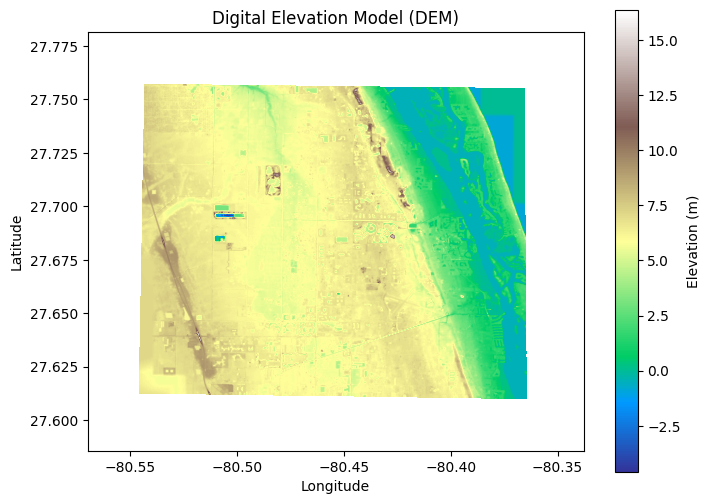

In [45]:
plot_dem(f"{leaf_path}\{smoothed_filename}.tif")

In [46]:
# Find no flow cells after the smoothing
wbt.find_no_flow_cells(
    f'{smoothed_filename}.tif', # Input DEM
    f"{smoothed_filename}_noflow.tif") # Output name

.\whitebox_tools.exe --run="FindNoFlowCells" --wd="c:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='wwv-10m_smoothed.tif' --output='wwv-10m_smoothed_noflow.tif' -v --compress_rasters=False

******************************
* Welcome to FindNoFlowCells *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress:

0

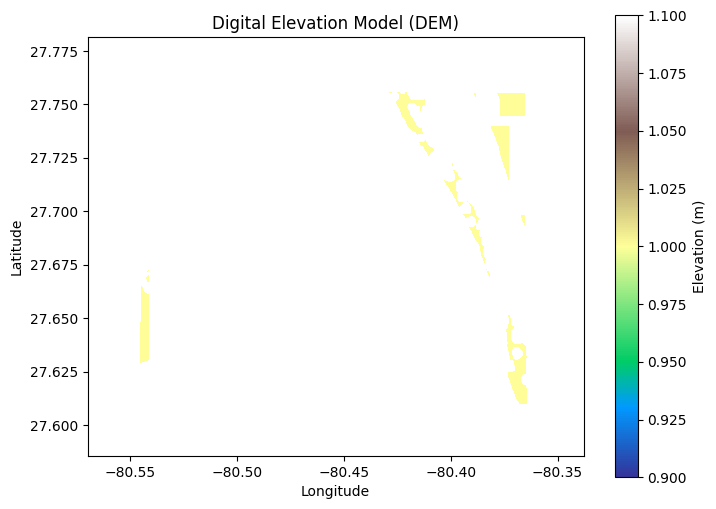

In [ ]:
# Ensure there are no major issues with the no flow output by checking the metadata
# There may be no flow cells around coastlines or bodies of water - this is normal

plot_dem(f"{leaf_path}\{smoothed_filename}_noflow.tif")

# Step 3 - Breach Depressions

This is a common step within DEM conditioning and will be the last step in the DEM pre-processing.

The output of this step is what will be used in the other notebook to delineate the microwatersheds.

In [75]:
# breach depressions on the smoothed DEM

conditioned_dem_filename = f"{smoothed_filename}_conditioned"

wbt.breach_depressions(
    f'{smoothed_filename}.tif', # Input DEM
    f"{conditioned_dem_filename}.tif") # Output name

.\whitebox_tools.exe --run="BreachDepressions" --wd="c:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='wwv-10m_smoothed.tif' --output='wwv-10m_smoothed_conditioned.tif' -v --compress_rasters=False

********************************
* Welcome to BreachDepressions *
* Powered by WhiteboxTools     *
* www.whiteboxgeo.com          *
********************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

0

In [77]:
# Find no flow cells 
wbt.find_no_flow_cells(
    f"{conditioned_dem_filename}.tif",
    f"{conditioned_dem_filename}_noflow.tif")

.\whitebox_tools.exe --run="FindNoFlowCells" --wd="c:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='wwv-10m_smoothed_conditioned.tif' --output='wwv-10m_smoothed_conditioned_noflow.tif' -v --compress_rasters=False

******************************
* Welcome to FindNoFlowCells *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%

0

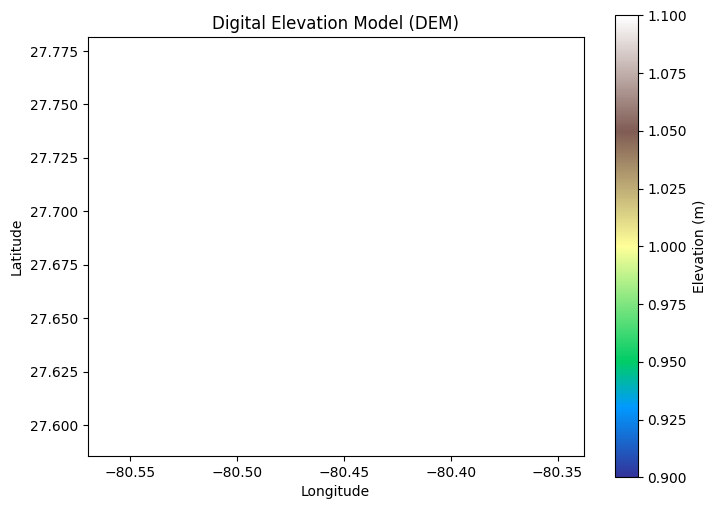

In [78]:
# Ensure there are no major issues with the no flow output by checking the metadata
# There may be no flow cells around coastlines or bodies of water - this is normal

plot_dem(f"{leaf_path}\{conditioned_dem_filename}_noflow.tif")

In [79]:
print("The final conditioned DEM is named: ")
print(f"{conditioned_dem_filename}.tif")

print("The relative file path is: ")
print(f"{data_path}\{conditioned_dem_filename}.tif")

The final conditioned DEM is named: 
wwv-10m_smoothed_conditioned.tif
The relative file path is: 
data-inputs\leafmap\wwv-10m_smoothed_conditioned.tif


# Pre-processing complete

The resulting breached output should be used as the INPUT into the second notebook to delineate the microwatersheds

Proceed to the second notebook:

[Microwatershed delineation notebook](2_DelineateMicrowatersheds.ipynb)

### Optional - sanity check flow direction, flow acc, and stream network output

Before proceeding to the Microwatershed delineation notebook, sanity checks on the flow direciton and stream network output are worthwhile and can be calculated simply with the Whitebox Tools package. Note, the Microwatershed delineation notebook uses another package 'Pysheds' instead of Whitebox tool, as there was a useful open-source wrapper for pysheds that delineates nested catchments for an entire area of interest, opposed to a single catchment.

In [80]:
# Calculate flow direction
wbt.d8_pointer(
    f"{conditioned_dem_filename}.tif", 
    f"{conditioned_dem_filename}_flow_direction.tif"
    )

.\whitebox_tools.exe --run="D8Pointer" --wd="c:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='wwv-10m_smoothed_conditioned.tif' --output='wwv-10m_smoothed_conditioned_flow_direction.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progr

0

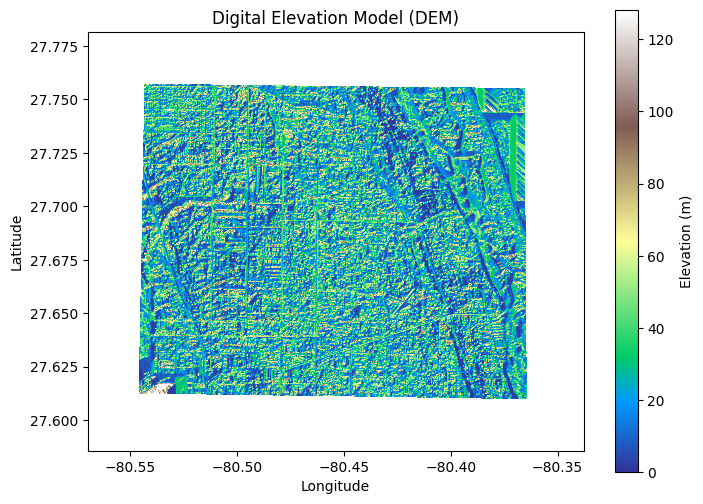

In [81]:
plot_dem(fr"{leaf_path}\{conditioned_dem_filename}_flow_direction.tif")

In [82]:
# Calculate flow accumulation
wbt.d8_flow_accumulation(
    f"{conditioned_dem_filename}.tif", 
    f"{conditioned_dem_filename}_flow_accum.tif")

.\whitebox_tools.exe --run="D8FlowAccumulation" --wd="c:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --input='wwv-10m_smoothed_conditioned.tif' --output='wwv-10m_smoothed_conditioned_flow_accum.tif' --out_type=cells -v --compress_rasters=False

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Flow directions: 0%
Flow directions: 1%
Flow directions: 2%
Flow directions: 3%
Flow directions: 4%
Flow directions: 5%
Flow directions: 6%
Flow directions: 7%
Flow directions: 8%
Flow directions: 9%
Flow directions: 10%
Flow directions: 11%
Flow directions: 12%
Flow directions: 13%
Flow directions: 14%
Flow directions: 15%
Flow directions: 16%
Flow directions: 17%
Flow directions: 18%
Flow directions: 19%
Flow directions: 20%
Flow directions: 21%
Flow directions: 22%
Flow directions: 23%
Flow directions: 24%
Flow 

0

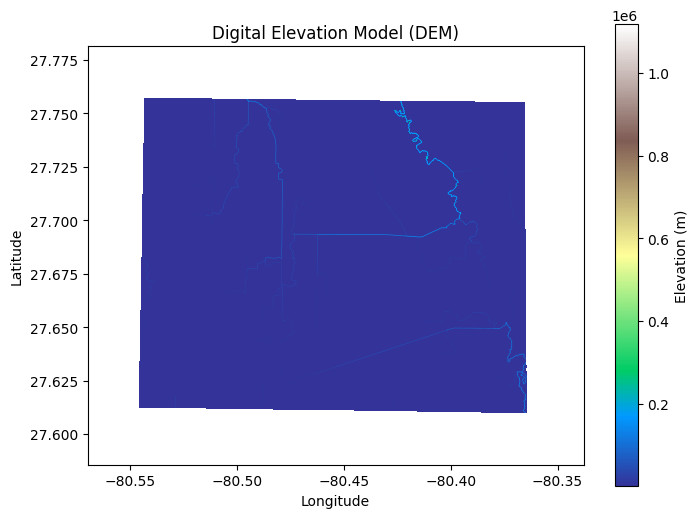

In [83]:
plot_dem(fr"{leaf_path}\{conditioned_dem_filename}_flow_accum.tif")

In [84]:
# Extract a stream network from the flow acc layer based on a minimum flow acc value
wbt.extract_streams(
    f"{conditioned_dem_filename}_flow_accum.tif", 
    f"{conditioned_dem_filename}_streams.tif", 
    threshold=750 # Flow acc threshold of which to derive streams. For a 10m DEM, a value of 750 will derive granular streams. 1500-2000 will derive fewer
    )

.\whitebox_tools.exe --run="ExtractStreams" --wd="c:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --flow_accum='wwv-10m_smoothed_conditioned_flow_accum.tif' --output='wwv-10m_smoothed_conditioned_streams.tif' --threshold='750' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress

0

In [85]:
# Convert the stream raster to vector
wbt.raster_streams_to_vector(
    f"{conditioned_dem_filename}_streams.tif", 
    d8_pntr=f"{conditioned_dem_filename}_flow_direction.tif", 
    output=f"{conditioned_dem_filename}_streams.shp"
)

.\whitebox_tools.exe --run="RasterStreamsToVector" --wd="c:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --streams='wwv-10m_smoothed_conditioned_streams.tif' --d8_pntr='wwv-10m_smoothed_conditioned_flow_direction.tif' --output='wwv-10m_smoothed_conditioned_streams.shp' -v --compress_rasters=False

************************************
* Welcome to RasterStreamsToVector *
* Powered by WhiteboxTools         *
* www.whiteboxgeo.com              *
************************************
Reading pointer data...
Reading streams data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 

0

In [86]:
# Set the CRS of the stream output to EPSG:4326 to align with the DEM
leafmap.vector_set_crs(
    source=fr"data-inputs\leafmap\{conditioned_dem_filename}_streams.shp", 
    output=f"{data_path}\{conditioned_dem_filename}_streams.shp", 
    crs="EPSG:4326"
    )

In [87]:
# Add the stream network output to the folium map
m.add_shp(
    f"{data_path}\{conditioned_dem_filename}_streams.shp", 
    layer_name="Streams Vector", 
    style={"color": "#ff0000", "weight": 3}
)

In [ ]:
# Render the folium map
m

In [88]:
print("The final conditioned DEM is named: ")
print(f"{conditioned_dem_filename}.tif")

print("The relative file path is: ")
print(f"{data_path}\{conditioned_dem_filename}.tif")

The final conditioned DEM is named: 
wwv-10m_smoothed_conditioned.tif
The relative file path is: 
data-inputs\leafmap\wwv-10m_smoothed_conditioned.tif


The resulting breached output should be used as the INPUT into the second notebook to delineate the microwatersheds

Proceed to the second notebook:

[Microwatershed delineation notebook](2_DelineateMicrowatersheds.ipynb)